# AS4501 Artificial neural networks
Francisco Förster

Class 2, traininig neural networks with Keras, evaluating and visualizing the results.



Based on Tensorflow tutorials.

You can run this notebook in colab in this link https://colab.research.google.com/github/fforster/AS4501/blob/main/ML_NNs/AS4501_Neural_networks_Tensorflow.ipynb

https://www.tensorflow.org/tutorials/keras/classification

# Load tensorflow


In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
tf.__version__

'2.3.0'

In [2]:
print(tf.config.experimental.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load MNIST

and convert the values to float

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train.shape

(60000, 28, 28)

Show some images

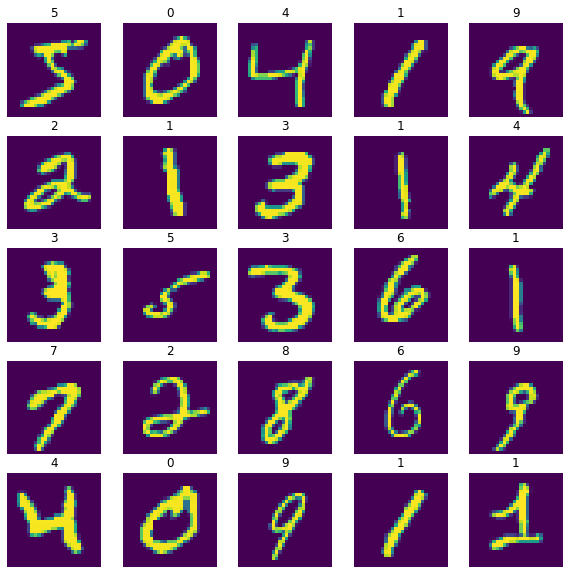

In [5]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    ax[i, j].imshow(x_train[5 * i + j])
    ax[i, j].axis(False)
    ax[i, j].set_title(y_train[5 * i + j])

Build a sequential model:
* input of 28 x 28
* connected to a dense layer of 128 neurons with a RELU activation function
* using a dropout of 20% of the neurons
* connected to a dense layer of 10 neurons, using a softmax activation function (output will be probabilities)




In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

Compile the model using the Adam optimizer, a sparse categorical crossentropy loss function, and report the accuracy.

Note that the sparse categorical crossentropy should be used when the labels are reported as integers. If the labels are reported with a vector of 1s and 0s one should use the categorical_crossentropy.

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Create checkpoints to be able to load any of the trained models

In [17]:
checkpoint_path = "training-1/cp-{epoch:04d}.ckpt" # each epoch will be saved
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Train the model


In [18]:
history = model.fit(x_train, y_train, epochs=15, 
                    validation_data=(x_test, y_test),
                    callbacks=cp_callback)

Epoch 1/15
1850/1875 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.9137
Epoch 00001: saving model to training-1/cp-0001.ckpt
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2960 - accuracy: 0.9140 - val_loss: 0.1476 - val_accuracy: 0.9548
Epoch 2/15
1864/1875 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9579
Epoch 00002: saving model to training-1/cp-0002.ckpt
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1437 - accuracy: 0.9578 - val_loss: 0.1040 - val_accuracy: 0.9668
Epoch 3/15
1855/1875 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9682
Epoch 00003: saving model to training-1/cp-0003.ckpt
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1076 - accuracy: 0.9682 - val_loss: 0.0895 - val_accuracy: 0.9726
Epoch 4/15
1850/1875 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9726
Epoch 00004: saving model to training-1/cp-0004.ck

Plot training and validation errors

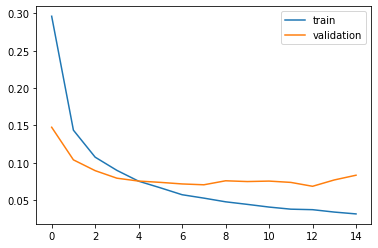

In [19]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label="train")
ax.plot(history.history['val_loss'], label="validation")
#ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()

Find the best model

In [20]:
np.argmin(history.history["val_loss"])

12

Show the latest model

In [21]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

latest

'training-1/cp-0015.ckpt'

Load the best model

In [22]:
model.load_weights('%s/cp-%04d.ckpt' % (checkpoint_dir, np.argmin(history.history["val_loss"]) + 1))

Evaluate the model again to check it's correct

In [23]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0686 - accuracy: 0.9801


[0.06862208992242813, 0.9800999760627747]

Get the predictions

In [24]:
predictions = model.predict(x_test)

Show one prediction and plot them showing their predicted class

In [25]:
predictions[0]

array([6.2453272e-11, 1.2020498e-13, 3.2177930e-08, 1.1277111e-06,
       6.7117307e-15, 3.3776849e-11, 4.7320903e-20, 9.9999869e-01,
       1.2383374e-09, 1.3968474e-07], dtype=float32)

In [28]:
np.sum(predictions, axis=1).mean()

1.0

In [26]:
np.argmax(predictions[0]), y_test[0]

(7, 7)

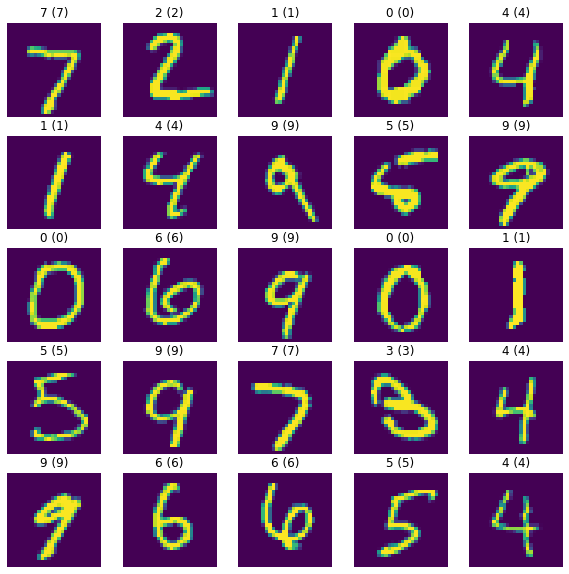

In [29]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    idx = 5 * i + j
    ax[i, j].imshow(x_test[idx])
    ax[i, j].axis(False)
    ax[i, j].set_title("%i (%i)" % (np.argmax(predictions[idx]), y_test[idx]))

Plot confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


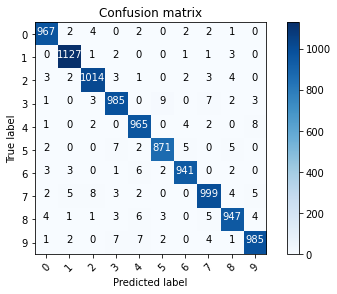

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, np.argmax(predictions, axis=1)), range(10))

# Try convolutional neural networks with a more complex dataset

In [33]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Let's define the class names (from https://www.tensorflow.org/tutorials/keras/classification)

In [34]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
label2name = dict(zip(range(len(class_names)), class_names))

In [35]:
label2name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Let's check the data shape

In [36]:
train_images.shape

(50000, 32, 32, 3)

Plot some examples

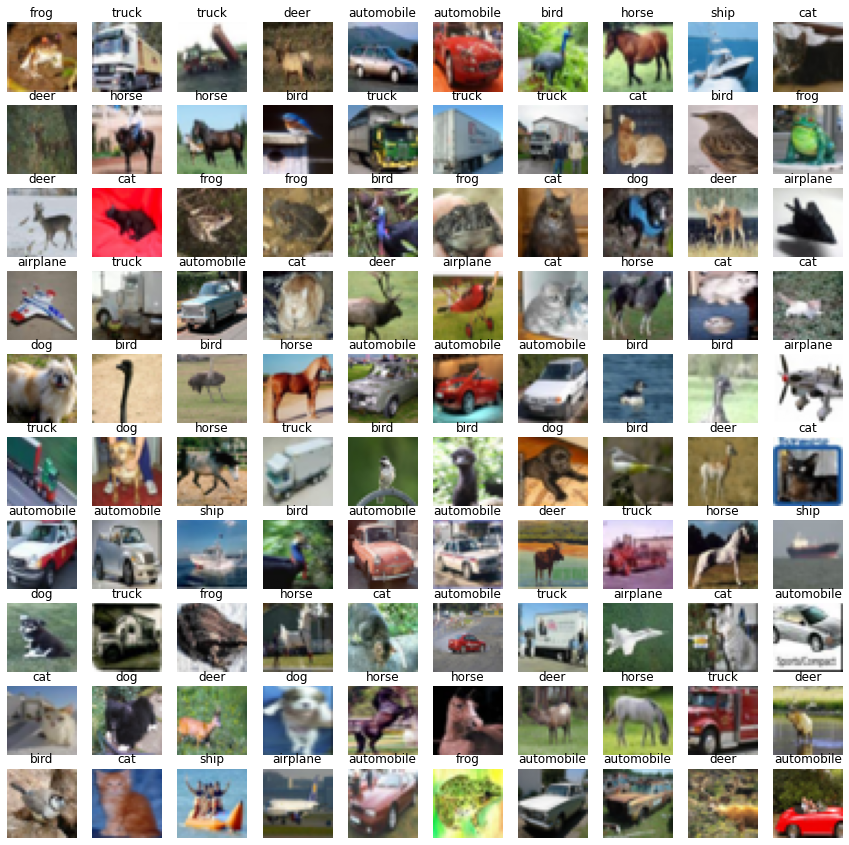

In [37]:
fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(15, 15))
for i in range(10):
  for j in range(10):
    idx = 10 * i + j
    ax[i, j].imshow(train_images[idx])
    ax[i, j].axis(False)
    ax[i, j].set_title(label2name[train_labels[idx][0]]) # note that the name

Let's create a convolutional neural network

In [39]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))


Let's show a summary of the architecture



In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

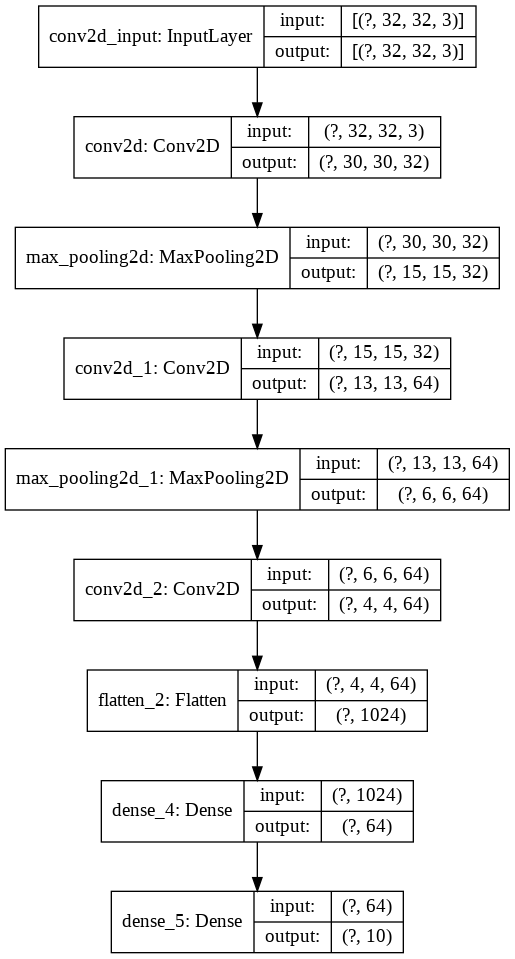

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try to visualize the network in http://alexlenail.me/NN-SVG/LeNet.html

Add checkpoints

In [42]:
checkpoint_path = "training-2/cp-{epoch:04d}.ckpt" # each epoch will be saved
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Fit sand save the history (make sure you select GPU acceleration in runtime)

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),
                    callbacks=cp_callback)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 1.4883 - accuracy: 0.4567
Epoch 00001: saving model to training-2/cp-0001.ckpt
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4883 - accuracy: 0.4567 - val_loss: 1.1985 - val_accuracy: 0.5641
Epoch 2/10
1554/1563 [============================>.] - ETA: 0s - loss: 1.1207 - accuracy: 0.6057
Epoch 00002: saving model to training-2/cp-0002.ckpt
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1201 - accuracy: 0.6059 - val_loss: 1.0609 - val_accuracy: 0.6318
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.6606
Epoch 00003: saving model to training-2/cp-0003.ckpt
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9714 - accuracy: 0.6606 - val_loss: 0.9381 - val_accuracy: 0.6696
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.6946
Epoch 00004: saving model to training-2/cp-0004.ck

Plot the loss function

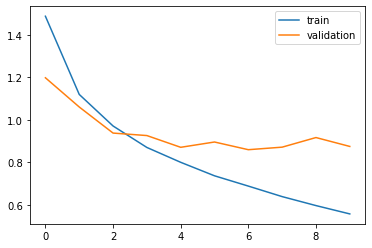

In [44]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label="train")
ax.plot(history.history['val_loss'], label="validation")
#ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()

Load best model

In [46]:
print("Loading model %i" % (np.argmin(history.history["val_loss"]) + 1))
model.load_weights('%s/cp-%04d.ckpt' % (checkpoint_dir, np.argmin(history.history["val_loss"]) + 1))

Loading model 7


In [47]:
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.8598 - accuracy: 0.7064


[0.859760046005249, 0.7063999772071838]

In [48]:
predictions = model.predict(test_images)

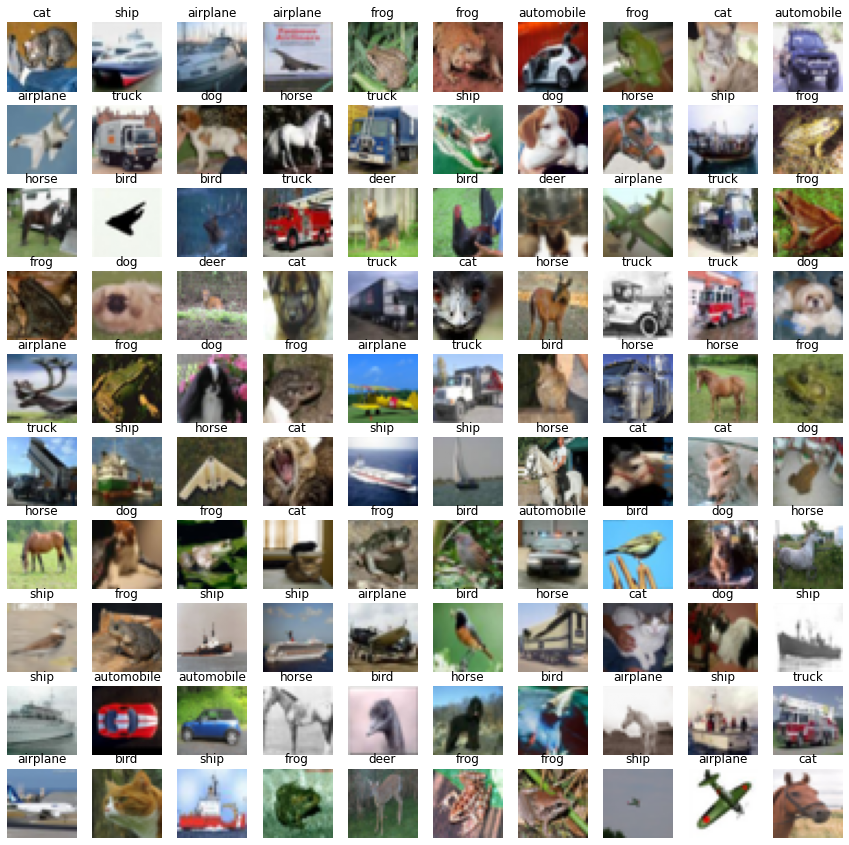

In [49]:
fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(15, 15))
for i in range(10):
  for j in range(10):
    idx = 10 * i + j
    ax[i, j].imshow(test_images[idx])
    ax[i, j].axis(False)
    ax[i, j].set_title("%s" % label2name[np.argmax(predictions[idx])])

Confusion matrix, without normalization


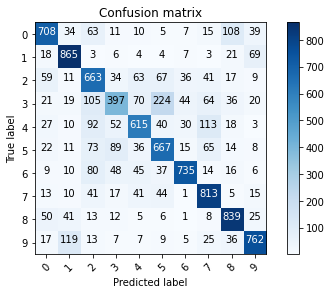

In [50]:
plot_confusion_matrix(confusion_matrix(test_labels, np.argmax(predictions, axis=1)), range(10))

In [51]:
label2name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Visualize the convolutional neural network

We will choose one image from the training set and we will see how it is transformed inside the network

automobile


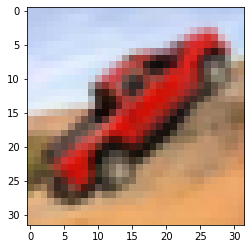

In [52]:
idx = 140
print(label2name[train_labels[idx][0]])
plt.imshow(train_images[idx])

We will extract the layers from the model and will create a network with the intermediate layers as outputs (see https://www.kaggle.com/dalalmanish/visualize-intermediate-layers)

In [53]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

We will create an output for this model for the image before (note that we add an additional dimension)

In [54]:
activations = activation_model.predict(np.expand_dims(train_images[idx], axis=0))

Check the number of outputs

In [55]:
len(activations)

8

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Let's confirm the shape of the outputs

In [57]:
for i in range(len(activations)): 
  print(activations[i].shape)

(1, 30, 30, 32)
(1, 15, 15, 32)
(1, 13, 13, 64)
(1, 6, 6, 64)
(1, 4, 4, 64)
(1, 1024)
(1, 64)
(1, 10)


We will be able to plot images when output has 4 dimensions (up to the 5th activation), afterwards the images are flattened.

Let's plot the first 10 filters for each of the outputs before.

(1, 30, 30, 32)
(1, 15, 15, 32)
(1, 13, 13, 64)
(1, 6, 6, 64)
(1, 4, 4, 64)


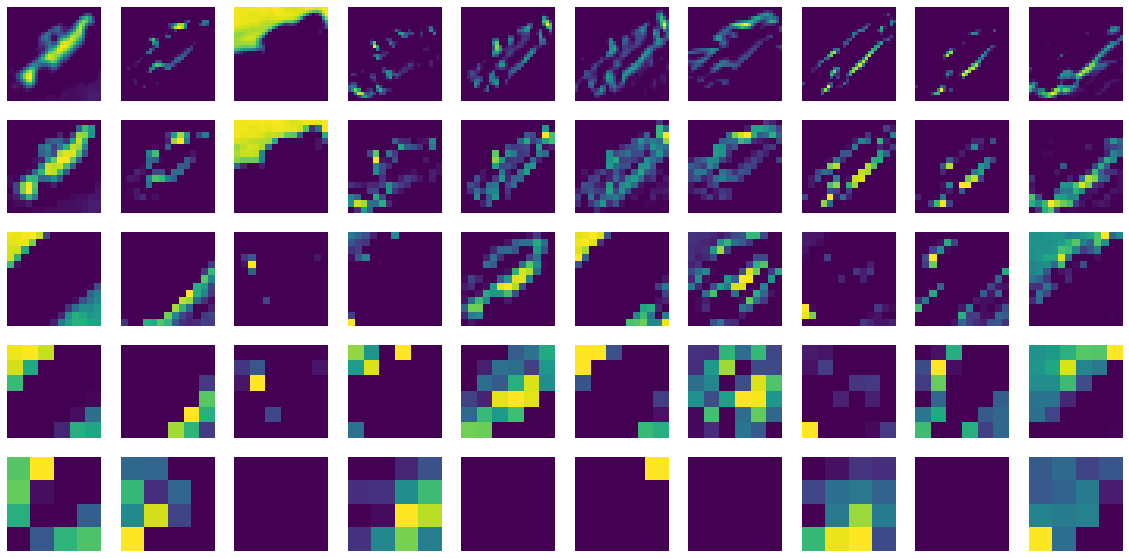

In [58]:
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for i in range(5): 
  print(activations[i].shape)
  for j in range(10):
    ax[i, j].imshow(activations[i][0, :, :, j], cmap='viridis')
    ax[i, j].axis(False)

You can see that some of the filters detect edges in different directions, others seems to smooth the image, other detect the background, etc..

Also note that the max pooling layers seem to only reduce the dimensions of the image, while only the convolutional layers change the image significantly.

Let's now plot the convolution kernels that are used to generate the images above

0 (3, 3, 3, 32)
Not a convolutional layer
2 (3, 3, 32, 64)
Not a convolutional layer
4 (3, 3, 64, 64)


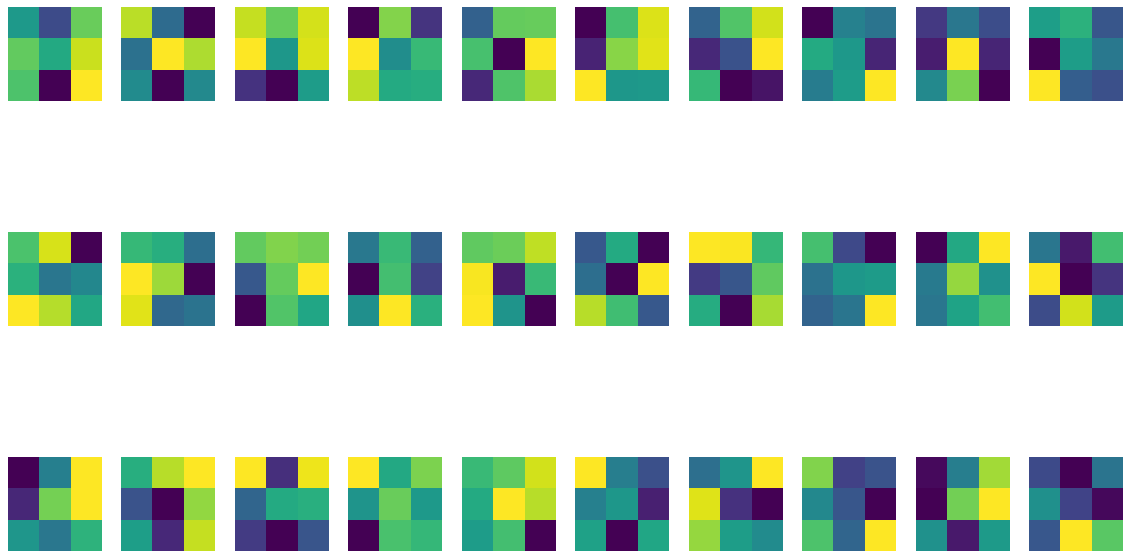

In [148]:
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for i in range(5): 
  try:
    print(i, model.layers[i].kernel.shape)
  except:
    print("Not a convolutional layer")
  for j in range(10):
      ax[i, j].axis(False)
      try: 
        kernel = model.layers[i].kernel[:, :, 0, j]
        ax[i, j].matshow(kernel, cmap='viridis')
      except:
        continue